Training data shape: (1460, 81)
Test data shape: (1459, 80)
Combined data shape: (2919, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  Hous

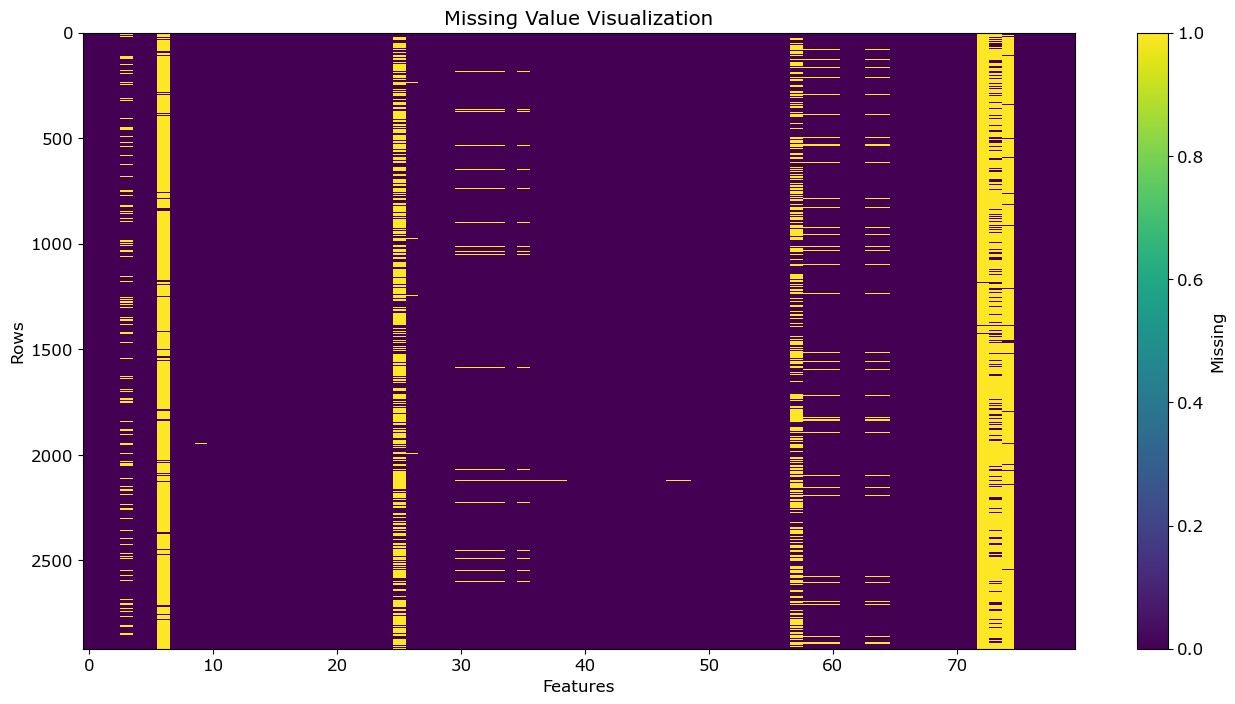

              Missing Count  Missing Percent
PoolQC                 2909            99.66
MiscFeature            2814            96.40
Alley                  2721            93.22
Fence                  2348            80.44
MasVnrType             1766            60.50
FireplaceQu            1420            48.65
LotFrontage             486            16.65
GarageQual              159             5.45
GarageCond              159             5.45
GarageYrBlt             159             5.45
GarageFinish            159             5.45
GarageType              157             5.38
BsmtExposure             82             2.81
BsmtCond                 82             2.81
BsmtQual                 81             2.77
BsmtFinType2             80             2.74
BsmtFinType1             79             2.71
MasVnrArea               23             0.79
MSZoning                  4             0.14
BsmtFullBath              2             0.07
BsmtHalfBath              2             0.07
Functional

In [1]:
# Import necessary libraries
import pandas as pd
import mlflow
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

# Set up plotting parameters using only matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Create a combined dataset to ensure consistent cleaning
# Save the test IDs first
test_ids = test_data['Id']
# Remove target from train set and combine with test set
train_target = train_data['SalePrice']
train_data = train_data.drop('SalePrice', axis=1)
combined_data = pd.concat([train_data, test_data], ignore_index=True, sort=False)
print(f"Combined data shape: {combined_data.shape}")

# Check data info to understand data types and missing values
combined_data.info()

# Alternative missing value visualization using just matplotlib
plt.figure(figsize=(16, 8))
plt.imshow(combined_data.isnull(), aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Missing')
plt.xlabel('Features')
plt.ylabel('Rows')
plt.title('Missing Value Visualization')
plt.show()

# Get a precise count of missing values per column
missing_values = combined_data.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(combined_data) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0]
print(missing_df)

In [2]:
import dagshub
dagshub.init(repo_owner='dkure20', repo_name='ml_2025', mlflow=True)

Accessing as dkure20

Initialized MLflow to track repo "dkure20/ml_2025"

Repository dkure20/ml_2025 initialized!

In [3]:
mlflow.set_experiment("Assignment 1-house prices")


<Experiment: artifact_location='mlflow-artifacts:/47dcb22556e14d768b9e0657c2b8a1c4', creation_time=1743953646982, experiment_id='1', last_update_time=1743953646982, lifecycle_stage='active', name='Assignment 1-house prices', tags={}>

mlflow.set_tracking_uri("https://dagshub.com/dkure20/ml_2025.mlflow")

In [4]:
na_means_none_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',  # External features
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',  # Garage features
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',  # Basement features
    'MasVnrType', 'MasVnrArea'  # Masonry veneer features
]

# Replace NAs with 'None' for categorical and 0 for numerical in these columns
for col in na_means_none_cols:
    if col in combined_data.columns:
        if combined_data[col].dtype == 'object':  # For categorical columns
            combined_data[col] = combined_data[col].fillna('None')
        else:  # For numerical columns
            combined_data[col] = combined_data[col].fillna(0)

In [5]:
combined_data['LotFrontage'] = combined_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()) if not pd.isna(x.median()) else x
)

# If any values still missing after neighborhood grouping, use global median
if combined_data['LotFrontage'].isnull().sum() > 0:
    combined_data['LotFrontage'] = combined_data['LotFrontage'].fillna(combined_data['LotFrontage'].median())

In [6]:
categorical_cols = combined_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if combined_data[col].isnull().sum() > 0:
        mode_val = combined_data[col].mode()[0]
        combined_data[col] = combined_data[col].fillna(mode_val)
        print(f"Filled {col} missing values with mode: {mode_val}")

Filled MSZoning missing values with mode: RL
Filled Utilities missing values with mode: AllPub
Filled Exterior1st missing values with mode: VinylSd
Filled Exterior2nd missing values with mode: VinylSd
Filled Electrical missing values with mode: SBrkr
Filled KitchenQual missing values with mode: TA
Filled Functional missing values with mode: Typ
Filled SaleType missing values with mode: WD


In [7]:
numerical_cols = combined_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if combined_data[col].isnull().sum() > 0:
        median_val = combined_data[col].median()
        combined_data[col] = combined_data[col].fillna(median_val)
        print(f"Filled {col} missing values with median: {median_val}")

Filled BsmtFinSF1 missing values with median: 368.5
Filled BsmtFinSF2 missing values with median: 0.0
Filled BsmtUnfSF missing values with median: 467.0
Filled TotalBsmtSF missing values with median: 989.5
Filled BsmtFullBath missing values with median: 0.0
Filled BsmtHalfBath missing values with median: 0.0
Filled GarageCars missing values with median: 2.0
Filled GarageArea missing values with median: 480.0


In [8]:
assert combined_data.isnull().sum().sum() == 0, "There are still missing values in the dataset!"
print("All missing values have been handled successfully!")

All missing values have been handled successfully!


In [9]:
def analyze_numeric_column(df, column):
    plt.figure(figsize=(16, 6))
    
    # First subplot: Histogram with KDE
    plt.subplot(1, 3, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    
    # Second subplot: Box plot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot for {column}')
    
    # Third subplot: Q-Q plot
    plt.subplot(1, 3, 3)
    stats.probplot(df[column].dropna(), plot=plt)
    plt.title(f'Q-Q plot for {column}')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate skewness
    skew = df[column].skew()
    print(f"Skewness for {column}: {skew:.4f}")
    
    # Identify outliers using IQR method
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    if not outliers.empty:
        print(f"Number of outliers in {column}: {len(outliers)}")
        print(f"Percentage of outliers: {(len(outliers)/len(df)*100):.2f}%")
        print(f"Outlier boundaries: Lower = {lower_bound:.2f}, Upper = {upper_bound:.2f}")
    else:
        print(f"No outliers detected in {column} using IQR method")
    
    return skew, outliers


--- Analysis for LotArea ---


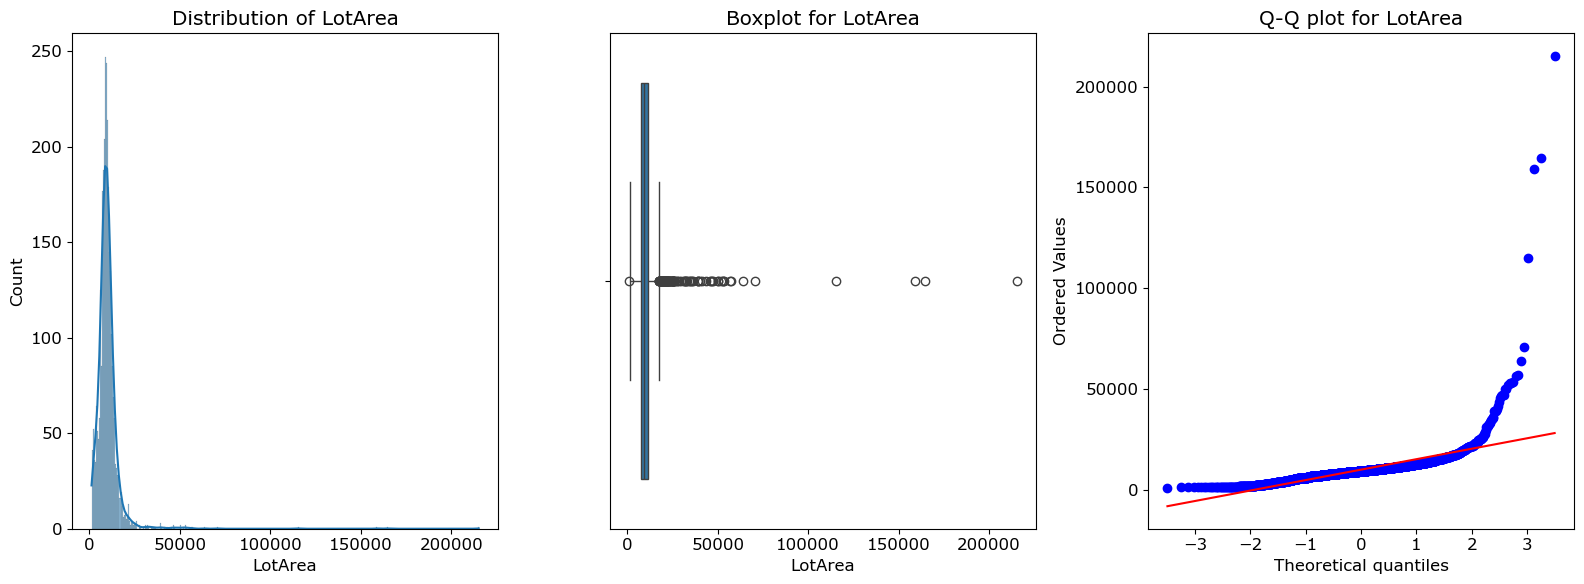

Skewness for LotArea: 12.8290
Number of outliers in LotArea: 128
Percentage of outliers: 4.39%
Outlier boundaries: Lower = 1340.00, Upper = 17708.00

--- Analysis for LotFrontage ---


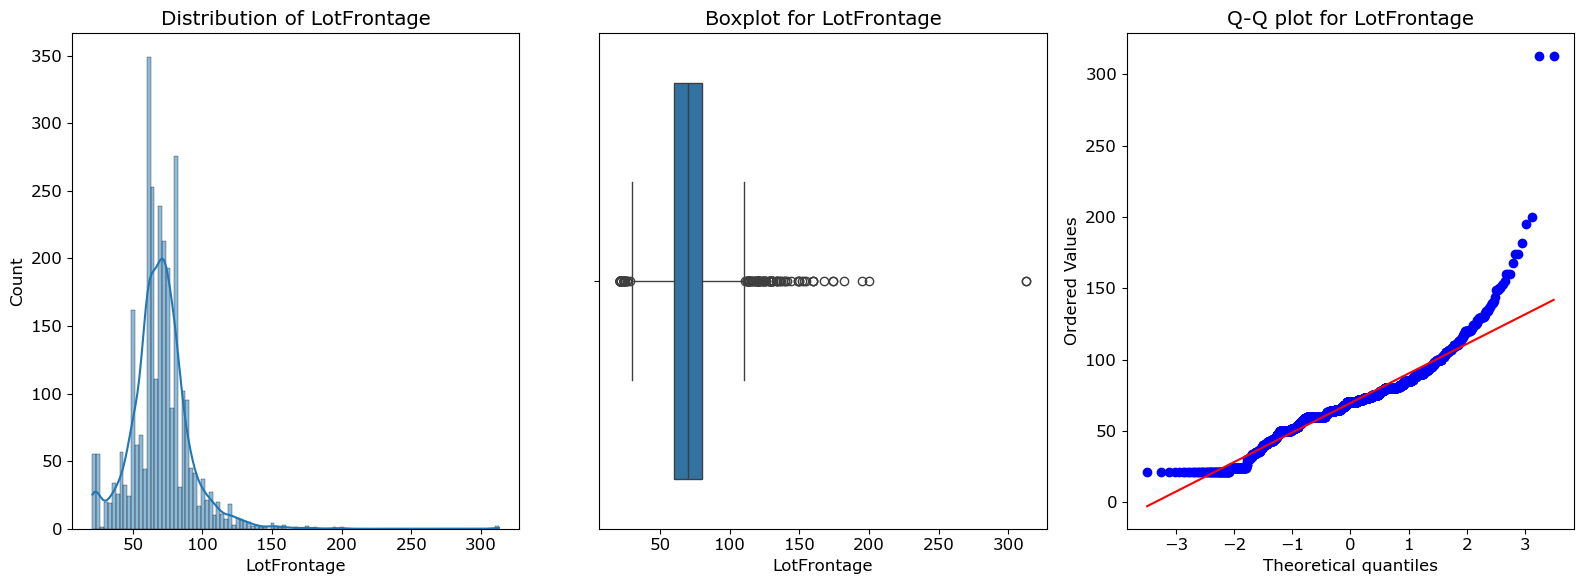

Skewness for LotFrontage: 1.5065
Number of outliers in LotFrontage: 206
Percentage of outliers: 7.06%
Outlier boundaries: Lower = 30.00, Upper = 110.00

--- Analysis for 1stFlrSF ---


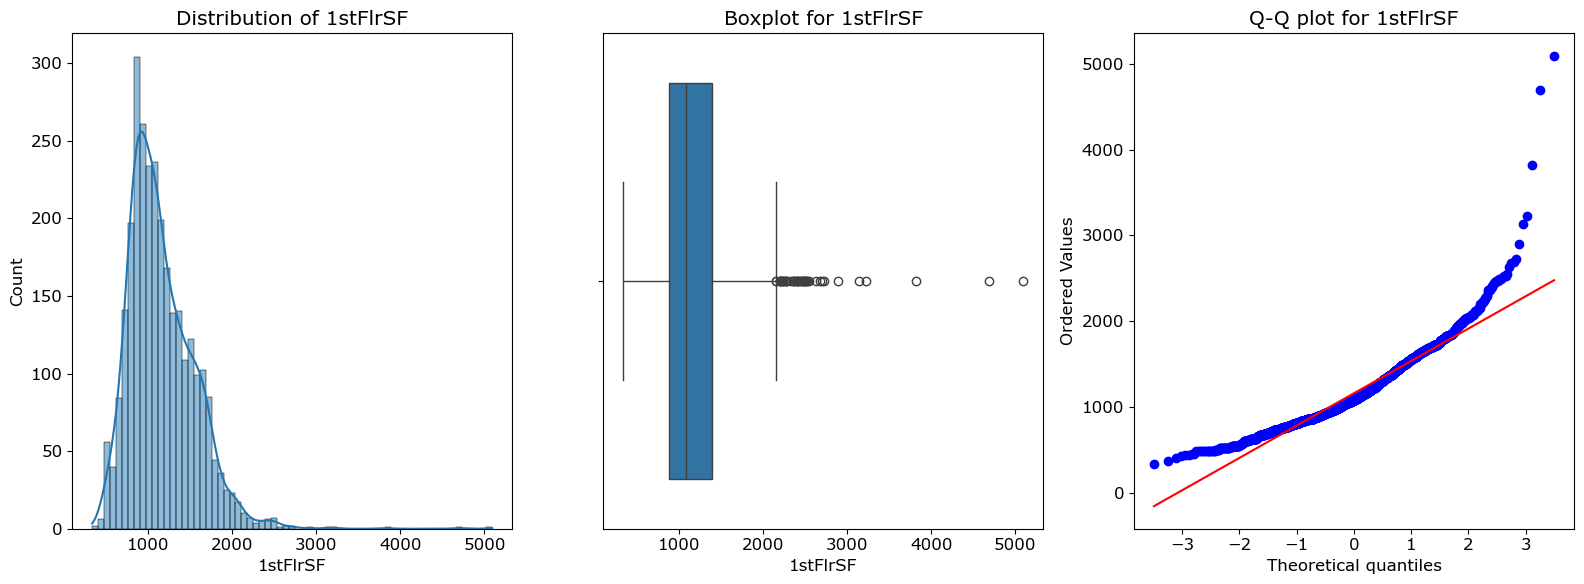

Skewness for 1stFlrSF: 1.4704
Number of outliers in 1stFlrSF: 42
Percentage of outliers: 1.44%
Outlier boundaries: Lower = 108.75, Upper = 2154.75

--- Analysis for 2ndFlrSF ---


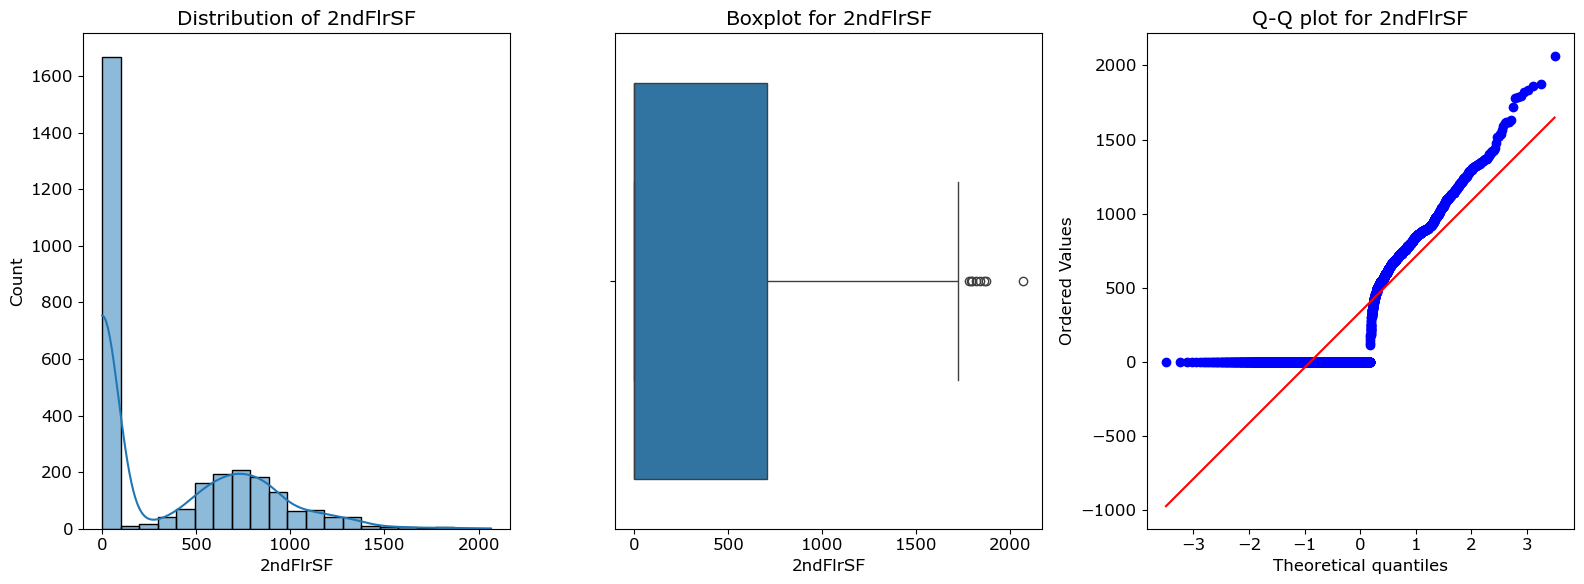

Skewness for 2ndFlrSF: 0.8621
Number of outliers in 2ndFlrSF: 8
Percentage of outliers: 0.27%
Outlier boundaries: Lower = -1056.00, Upper = 1760.00

--- Analysis for TotalBsmtSF ---


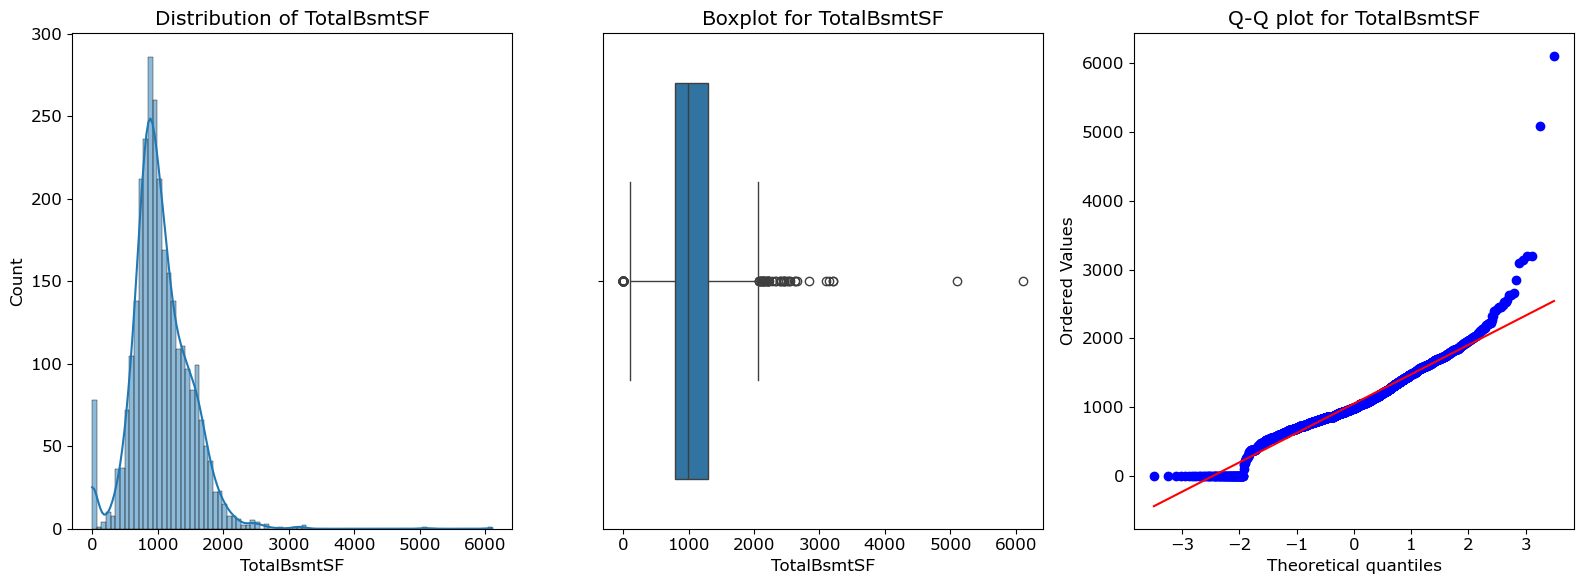

Skewness for TotalBsmtSF: 1.1632
Number of outliers in TotalBsmtSF: 122
Percentage of outliers: 4.18%
Outlier boundaries: Lower = 29.50, Upper = 2065.50

--- Analysis for GrLivArea ---


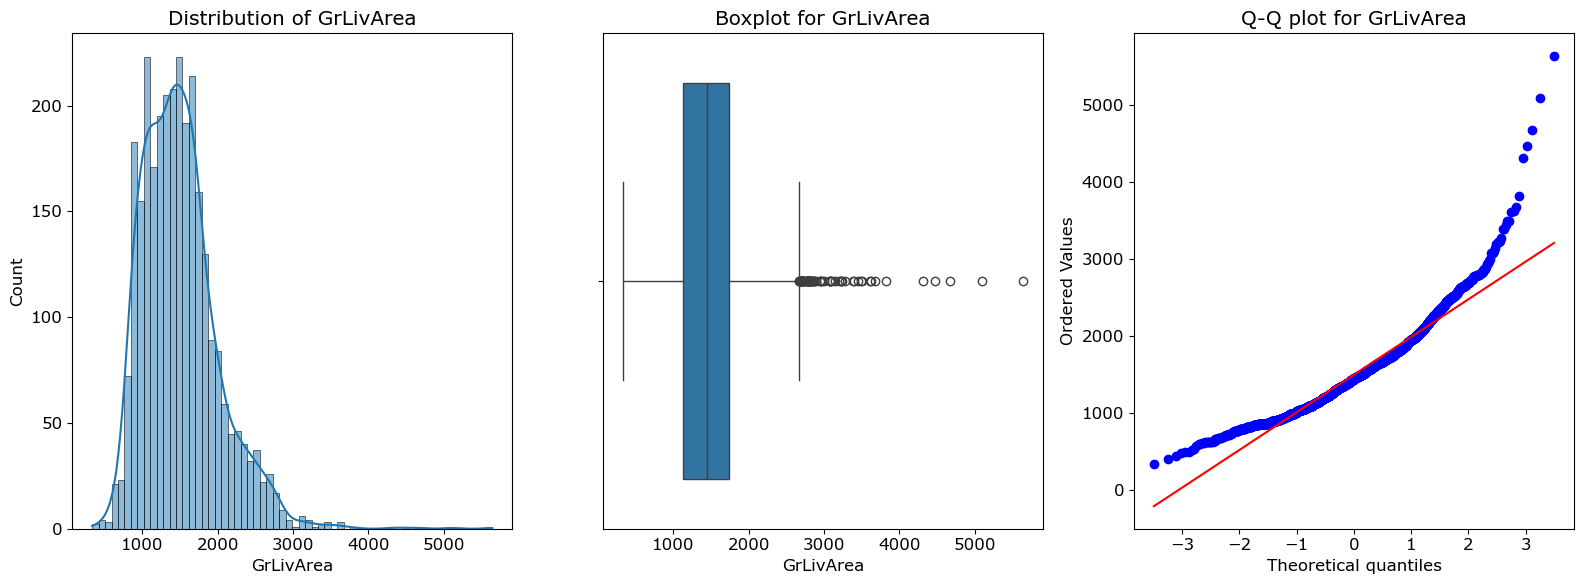

Skewness for GrLivArea: 1.2700
Number of outliers in GrLivArea: 74
Percentage of outliers: 2.54%
Outlier boundaries: Lower = 199.75, Upper = 2669.75

--- Analysis for BsmtFinSF1 ---


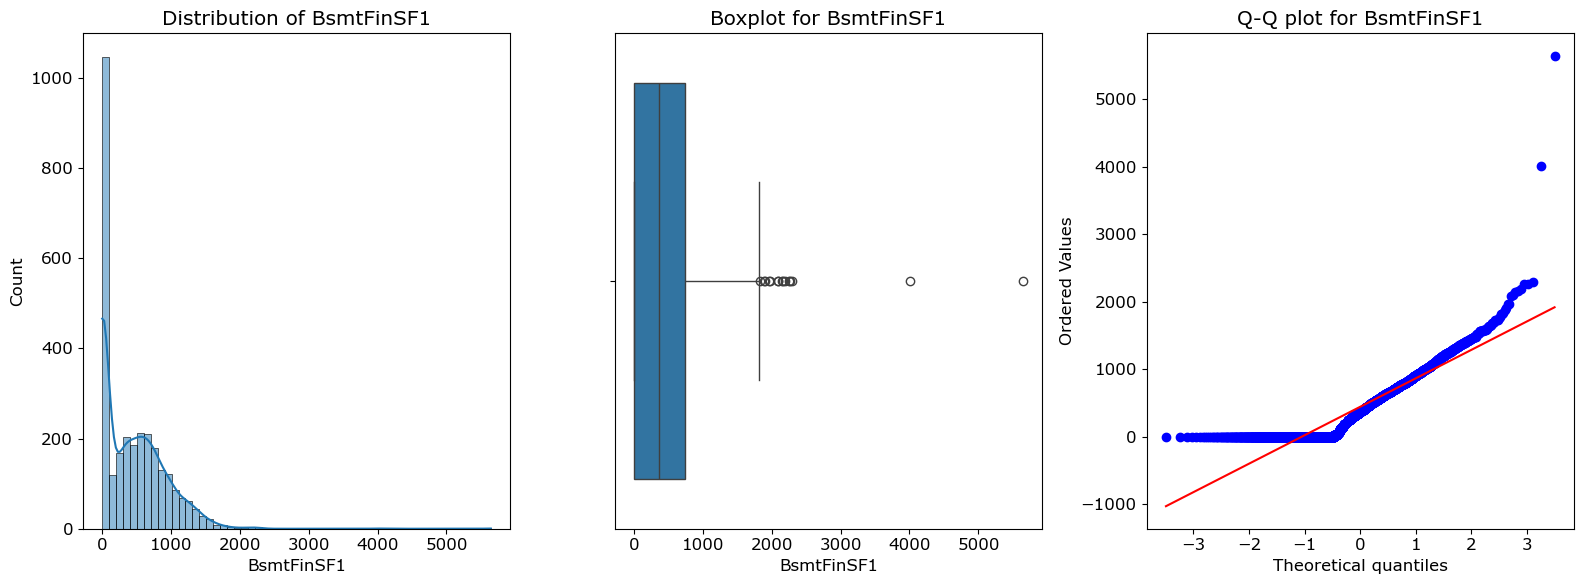

Skewness for BsmtFinSF1: 1.4261
Number of outliers in BsmtFinSF1: 15
Percentage of outliers: 0.51%
Outlier boundaries: Lower = -1099.50, Upper = 1832.50

--- Analysis for MasVnrArea ---


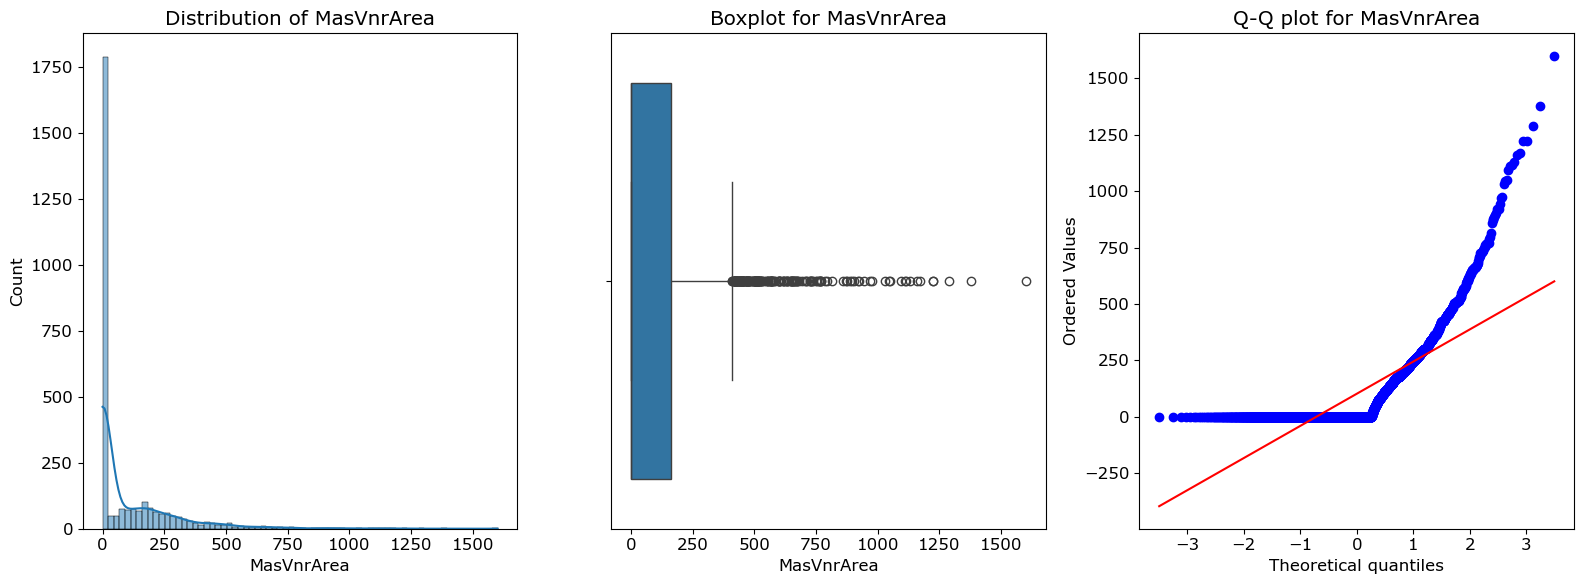

Skewness for MasVnrArea: 2.6149
Number of outliers in MasVnrArea: 202
Percentage of outliers: 6.92%
Outlier boundaries: Lower = -245.25, Upper = 408.75

--- Analysis for GarageArea ---


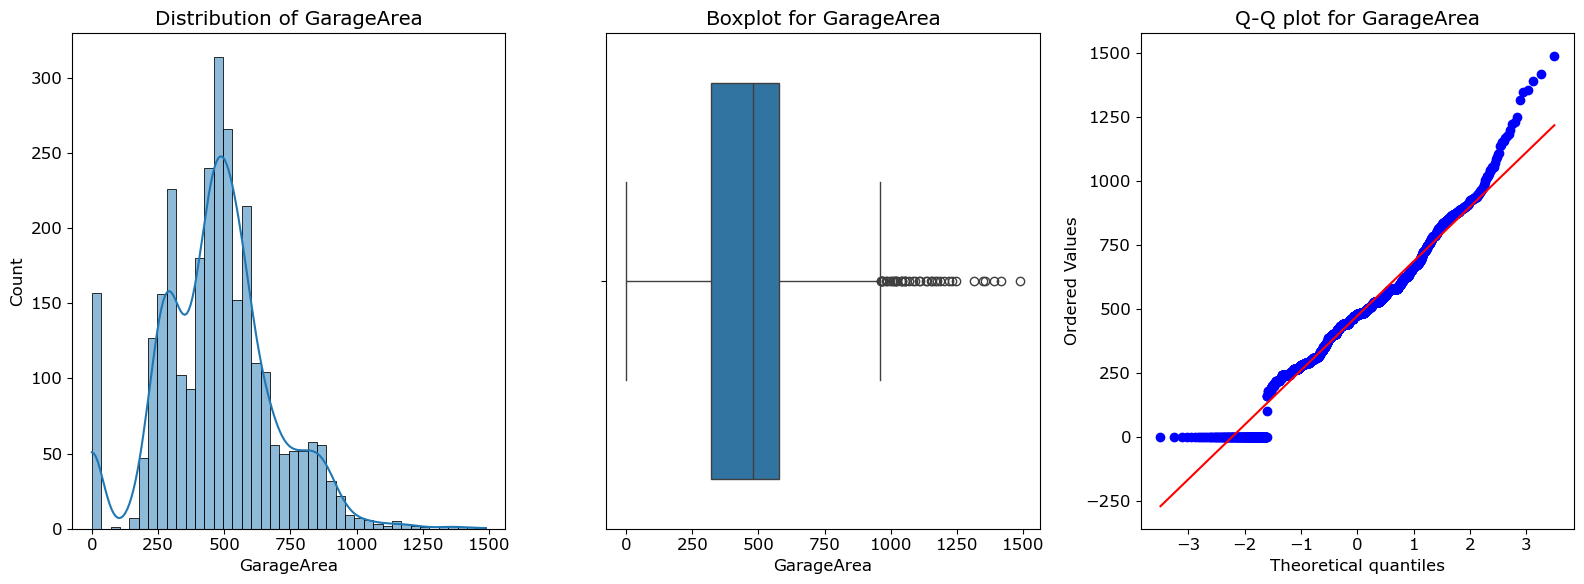

Skewness for GarageArea: 0.2413
Number of outliers in GarageArea: 42
Percentage of outliers: 1.44%
Outlier boundaries: Lower = -64.00, Upper = 960.00


In [10]:
important_numeric_cols = ['LotArea', 'LotFrontage', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 
                         'GrLivArea', 'BsmtFinSF1', 'MasVnrArea', 'GarageArea']

# Dictionary to store skewness values
skewness_dict = {}

# Analyze each important numerical column
for col in important_numeric_cols:
    print(f"\n--- Analysis for {col} ---")
    skew, outliers = analyze_numeric_column(combined_data, col)
    skewness_dict[col] = skew

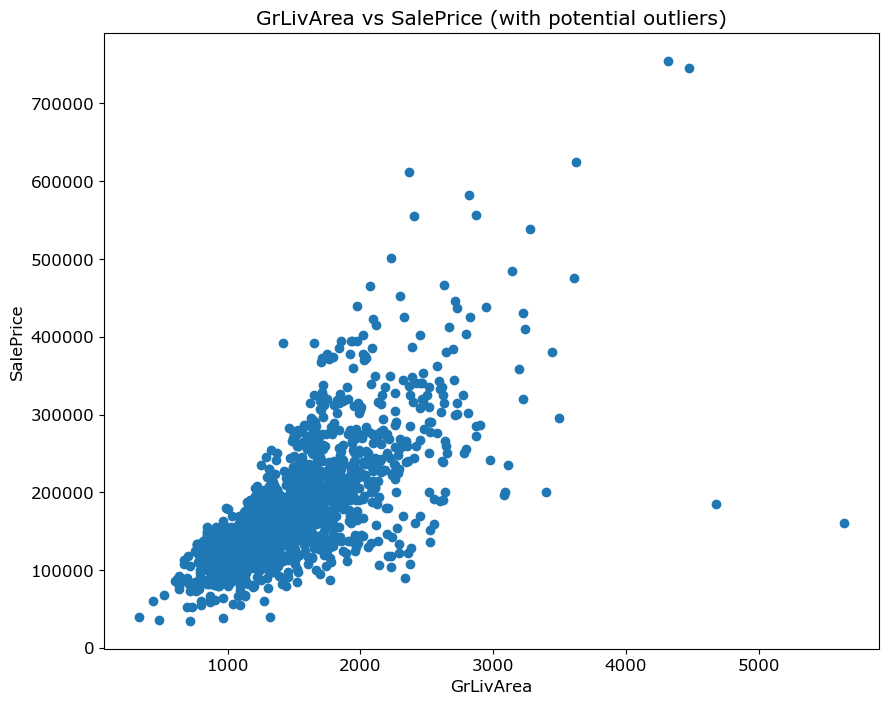

In [11]:
train_size = len(train_data)

# Use only the training portion of the combined data for the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(combined_data.iloc[:train_size]['GrLivArea'], train_target)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice (with potential outliers)')
plt.show()

In [12]:
train_size = len(train_data)

In [13]:
extreme_outliers_idx = combined_data.iloc[:train_size].query('GrLivArea > 4000').index

In [14]:
if len(extreme_outliers_idx) > 0:
    print(f"Removing {len(extreme_outliers_idx)} extreme outliers from the training data")
    combined_data = combined_data.drop(extreme_outliers_idx)
    # Also remove from the target
    train_target = train_target.drop(extreme_outliers_idx)

Removing 4 extreme outliers from the training data


In [15]:
skewed_features = [col for col, skew in skewness_dict.items() if abs(skew) > 0.75]
print(f"\nSkewed features to transform: {skewed_features}")


Skewed features to transform: ['LotArea', 'LotFrontage', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1', 'MasVnrArea']


In [16]:
for feature in skewed_features:
    # Make sure all values are positive for log transform
    if (combined_data[feature] <= 0).any():
        combined_data[feature] = combined_data[feature] - combined_data[feature].min() + 1
    
    # Apply log transformation
    combined_data[feature] = np.log1p(combined_data[feature])
    print(f"Applied log transformation to {feature}. New skewness: {combined_data[feature].skew():.4f}")

Applied log transformation to LotArea. New skewness: -0.5333
Applied log transformation to LotFrontage. New skewness: -1.0773
Applied log transformation to 1stFlrSF. New skewness: 0.0253
Applied log transformation to 2ndFlrSF. New skewness: 0.3121
Applied log transformation to TotalBsmtSF. New skewness: -4.8224
Applied log transformation to GrLivArea. New skewness: -0.0447
Applied log transformation to BsmtFinSF1. New skewness: -0.5854
Applied log transformation to MasVnrArea. New skewness: 0.5679


In [17]:
print(f"Missing values after cleaning: {combined_data.isnull().sum().sum()}")
print(f"Data types after cleaning: {combined_data.dtypes}")

Missing values after cleaning: 0
Data types after cleaning: Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea          float64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object


In [18]:
import mlflow
with mlflow.start_run(run_name="data_cleaning"):
    mlflow.log_param("missing_values_handled", "imputation and removal")
    mlflow.log_param("outliers_removed", "IQR and specific handling for GrLivArea")
    mlflow.log_param("skewness_transformed", "log transformations for skewed features")
    mlflow.log_param("features_processed", "replaced NAs with domain knowledge, handled outliers, etc.")

🏃 View run data_cleaning at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/e4a295d65147475b9628dd5eb8a98775
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1


In [19]:
# ---------- PART 6: FEATURE ENGINEERING ----------

# Create new features that might be predictive
print("\nPerforming feature engineering...")

# Total square footage
combined_data['TotalSF'] = combined_data['TotalBsmtSF'] + combined_data['1stFlrSF'] + combined_data['2ndFlrSF']

# Total bathrooms
combined_data['TotalBathrooms'] = combined_data['FullBath'] + (0.5 * combined_data['HalfBath']) + \
                                  combined_data['BsmtFullBath'] + (0.5 * combined_data['BsmtHalfBath'])

# House age when sold and remodeled status
combined_data['HouseAge'] = combined_data['YrSold'] - combined_data['YearBuilt']
combined_data['IsRemodeled'] = (combined_data['YearRemodAdd'] != combined_data['YearBuilt']).astype(int)
combined_data['RemodAge'] = combined_data['YrSold'] - combined_data['YearRemodAdd']

# Total porch area
combined_data['TotalPorchSF'] = combined_data['OpenPorchSF'] + combined_data['EnclosedPorch'] + \
                               combined_data['3SsnPorch'] + combined_data['ScreenPorch']

# Has features
combined_data['HasPool'] = combined_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
combined_data['Has2ndFloor'] = combined_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
combined_data['HasGarage'] = combined_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
combined_data['HasBsmt'] = combined_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
combined_data['HasFireplace'] = combined_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Quality-related composite scores
combined_data['OverallGrade'] = combined_data['OverallQual'] * combined_data['OverallCond']

# Neighborhood and price level interaction
# First, create a price level indicator for neighborhoods (requires training data)


# Create relative size metrics (how a house compares to its neighborhood)
neighborhood_size = train_data.groupby('Neighborhood')['GrLivArea'].median().reset_index()
neighborhood_size.columns = ['Neighborhood', 'NeighborhoodMedianSize']
combined_data = pd.merge(combined_data, neighborhood_size, on='Neighborhood', how='left')
combined_data['RelativeSize'] = combined_data['GrLivArea'] / combined_data['NeighborhoodMedianSize']

# Ratio features
combined_data['LotRatio'] = combined_data['LotArea'] / combined_data['LotFrontage']
combined_data['RoomRatio'] = combined_data['TotRmsAbvGrd'] / combined_data['GrLivArea']
combined_data['GarageRatio'] = combined_data['GarageArea'] / combined_data['GrLivArea']

# Living area proportions
combined_data['1stFlrRatio'] = combined_data['1stFlrSF'] / combined_data['GrLivArea']
combined_data['2ndFlrRatio'] = combined_data['2ndFlrSF'] / combined_data['GrLivArea']
combined_data['BsmtRatio'] = combined_data['TotalBsmtSF'] / combined_data['GrLivArea']

# Handle potential division by zero in ratio calculations
ratio_cols = ['LotRatio', 'RoomRatio', 'GarageRatio', '1stFlrRatio', '2ndFlrRatio', 'BsmtRatio', 'RelativeSize']
for col in ratio_cols:
    combined_data[col] = combined_data[col].replace([np.inf, -np.inf], np.nan)
    combined_data[col] = combined_data[col].fillna(0)

print(f"Created {combined_data.shape[1] - 80} new engineered features")


Performing feature engineering...
Created 20 new engineered features


In [20]:
print(combined_data.isnull().sum())

# Check data types of the new features
print(combined_data.dtypes)

Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
              ..
RoomRatio      0
GarageRatio    0
1stFlrRatio    0
2ndFlrRatio    0
BsmtRatio      0
Length: 100, dtype: int64
Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea        float64
                ...   
RoomRatio      float64
GarageRatio    float64
1stFlrRatio    float64
2ndFlrRatio    float64
BsmtRatio      float64
Length: 100, dtype: object


In [21]:


# 1. Correlation Analysis with Target
def correlation_selection(X, y, threshold=0.1):
    # Convert to DataFrame if it's not already
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    # Calculate correlation with target
    corr_with_target = pd.DataFrame()
    corr_with_target['feature'] = X.columns
    corr_with_target['correlation'] = [np.corrcoef(X[col], y)[0, 1] for col in X.columns]
    corr_with_target['abs_correlation'] = corr_with_target['correlation'].abs()
    
    # Sort by absolute correlation
    corr_with_target = corr_with_target.sort_values('abs_correlation', ascending=False)
    
    # Select features with correlation above threshold
    selected_features = corr_with_target[corr_with_target['abs_correlation'] > threshold]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features based on correlation > {threshold}")
    return selected_features, corr_with_target

# 2. Statistical Feature Selection
def statistical_selection(X, y, k=50):
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    
    # Get selected features
    selected_mask = selector.get_support()
    selected_features = X.columns[selected_mask].tolist()
    
    # Get feature scores
    feature_scores = pd.DataFrame()
    feature_scores['feature'] = X.columns
    feature_scores['score'] = selector.scores_
    feature_scores = feature_scores.sort_values('score', ascending=False)
    
    print(f"Selected top {k} features based on f_regression")
    return selected_features, feature_scores

# 3. Recursive Feature Elimination
def rfe_selection(X, y, n_features=50, step=1):
    # Initialize estimator
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Initialize RFE
    selector = RFE(estimator, n_features_to_select=n_features, step=step)
    selector.fit(X, y)
    
    # Get selected features
    selected_mask = selector.get_support()
    selected_features = X.columns[selected_mask].tolist()
    
    # Get feature rankings
    feature_rankings = pd.DataFrame()
    feature_rankings['feature'] = X.columns
    feature_rankings['ranking'] = selector.ranking_
    feature_rankings = feature_rankings.sort_values('ranking')
    
    print(f"Selected {n_features} features based on RFE")
    return selected_features, feature_rankings

# 4. Feature Importance from Tree-based Models
def tree_importance_selection(X, y, threshold=0.01):
    # Initialize model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit model
    model.fit(X, y)
    
    # Get feature importance
    importances = pd.DataFrame()
    importances['feature'] = X.columns
    importances['importance'] = model.feature_importances_
    importances = importances.sort_values('importance', ascending=False)
    
    # Select features with importance above threshold
    selected_features = importances[importances['importance'] > threshold]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features based on importance > {threshold}")
    return selected_features, importances

# 5. L1 Regularization (Lasso) for Feature Selection
def lasso_selection(X, y, alpha=0.01):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit model
    model = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    model.fit(X_scaled, y)
    
    # Get feature coefficients
    coefficients = pd.DataFrame()
    coefficients['feature'] = X.columns
    coefficients['coefficient'] = model.coef_
    coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
    coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
    
    # Select features with non-zero coefficients
    selected_features = coefficients[coefficients['coefficient'] != 0]['feature'].tolist()
    
    print(f"Selected {len(selected_features)} features with non-zero Lasso coefficients")
    return selected_features, coefficients

# Combine feature selection methods for robust selection
def ensemble_feature_selection(X, y):
    # Run all selection methods
    corr_features, _ = correlation_selection(X, y, threshold=0.1)
    stat_features, _ = statistical_selection(X, y, k=min(50, X.shape[1] // 2))
    rfe_features, _ = rfe_selection(X, y, n_features=min(50, X.shape[1] // 2))
    tree_features, _ = tree_importance_selection(X, y, threshold=0.01)
    lasso_features, _ = lasso_selection(X, y, alpha=0.01)
    
    # Count how many methods selected each feature
    all_features = list(set(corr_features + stat_features + rfe_features + tree_features + lasso_features))
    feature_votes = {}
    
    for feature in all_features:
        votes = 0
        if feature in corr_features: votes += 1
        if feature in stat_features: votes += 1
        if feature in rfe_features: votes += 1
        if feature in tree_features: votes += 1
        if feature in lasso_features: votes += 1
        feature_votes[feature] = votes
    
    # Convert to DataFrame
    feature_votes_df = pd.DataFrame({
        'feature': list(feature_votes.keys()),
        'votes': list(feature_votes.values())
    }).sort_values('votes', ascending=False)
    
    # Select features voted by at least 3 methods
    consensus_features = feature_votes_df[feature_votes_df['votes'] >= 3]['feature'].tolist()
    
    print(f"Selected {len(consensus_features)} consensus features (voted by ≥3 methods)")
    return consensus_features, feature_votes_df

In [22]:
# Define evaluation metrics
def evaluate_model(model, X, y, cv=5):
    # Negative RMSE for scoring (higher is better)
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, 
                                        scoring='neg_mean_squared_error', 
                                        cv=cv))
    mae_scores = -cross_val_score(model, X, y, 
                                scoring='neg_mean_absolute_error', 
                                cv=cv)
    r2_scores = cross_val_score(model, X, y, 
                              scoring='r2', 
                              cv=cv)
    
    return {
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'MAE_mean': mae_scores.mean(),
        'MAE_std': mae_scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std()
    }

# 1. Linear Regression (baseline)
def train_linear_regression(X, y):
    model = LinearRegression()
    return model, evaluate_model(model, X, y)

# 2. Ridge Regression with GridSearchCV
def train_ridge_regression(X, y):
    # Parameter grid
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    }
    
    # Initialize model
    model = Ridge(random_state=42)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_model, evaluate_model(best_model, X, y), best_params

# 5. Random Forest with RandomizedSearchCV
def train_random_forest(X, y):
    # Parameter grid
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', None]
    }
    
    # Initialize model
    model = RandomForestRegressor(random_state=42)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )
    
    random_search.fit(X, y)
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    
    return best_model, evaluate_model(best_model, X, y), best_params

# 7. XGBoost with RandomizedSearchCV
def train_xgboost(X, y):
    # Parameter grid
    param_dist = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6, 8],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3]
    }
    
    # Initialize model
    model = XGBRegressor(random_state=42)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )
    
    random_search.fit(X, y)
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    
    return best_model, evaluate_model(best_model, X, y), best_params


# Train all models and compare
def train_and_compare_models(X, y):
    models = {
        'Linear Regression': train_linear_regression,
        'Ridge Regression': train_ridge_regression,
        'Random Forest': train_random_forest,
        'XGBoost': train_xgboost
    }
    
    results = {}
    best_models = {}
    best_params = {}
    
    for name, trainer in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        
        if name == 'Linear Regression':
            model, evaluation = trainer(X, y)
            best_params[name] = None
        else:
            model, evaluation, params = trainer(X, y)
            best_params[name] = params
            
        training_time = time.time() - start_time
        
        results[name] = evaluation
        results[name]['training_time'] = training_time
        best_models[name] = model
        
        print(f"  RMSE: {evaluation['RMSE_mean']:.4f} (±{evaluation['RMSE_std']:.4f})")
        print(f"  R2: {evaluation['R2_mean']:.4f} (±{evaluation['R2_std']:.4f})")
        print(f"  Time: {training_time:.2f}s")
        print(f"  Best params: {best_params[name]}")
        print("-" * 50)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('RMSE_mean')
    
    return results_df, best_models, best_params

# Model stacking for even better performance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold

class StackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.base_models_ = None
        self.meta_model_ = None
        
    def fit(self, X, y):
        self.base_models_ = [list() for _ in range(len(self.base_models))]
        
        # Train base models
        for i, model in enumerate(self.base_models):
            model.fit(X, y)
            self.base_models_[i] = model
            
        # Create meta features
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])
        
        # Train meta model
        self.meta_model_ = self.meta_model.fit(meta_features, y)
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

def train_stacked_model(X, y, best_models):
    # Select top performing models for stacking
    base_models = [
        best_models['XGBoost'],
        best_models['LightGBM'],
        best_models['Gradient Boosting'],
        best_models['Random Forest']
    ]
    
    # Meta model
    meta_model = Ridge(alpha=0.1)
    
    # Create stacked model
    stacked_model = StackingRegressor(
        base_models=base_models,
        meta_model=meta_model
    )
    
    # Evaluate stacked model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train stacked model
        stacked_model.fit(X_train, y_train)
        
        # Predict
        y_pred = stacked_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    # Average scores
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print("Stacked Model Performance:")
    print(f"  RMSE: {avg_rmse:.4f}")
    print(f"  R2: {avg_r2:.4f}")
    
    # Train final stacked model on all data
    final_stacked_model = StackingRegressor(
        base_models=base_models,
        meta_model=meta_model
    )
    final_stacked_model.fit(X, y)
    
    return final_stacked_model, {
        'RMSE_mean': avg_rmse,
        'R2_mean': avg_r2
    }

In [23]:
def select_final_model(results_df, best_models, X, y):
    """
    Select the best model based on performance metrics and other considerations
    """
    print("Model Comparison Results:")
    print(results_df[['RMSE_mean', 'RMSE_std', 'R2_mean', 'R2_std', 'training_time']])
    
    # Options for final model
    # 1. Best single model by RMSE
    best_single_model_name = results_df.index[0]
    best_single_model = best_models[best_single_model_name]
    
    print(f"\nBest single model: {best_single_model_name}")
    print(f"RMSE: {results_df.loc[best_single_model_name, 'RMSE_mean']:.4f}")
    print(f"R2: {results_df.loc[best_single_model_name, 'R2_mean']:.4f}")
    
    # We need to adjust the stacked model since you've removed some models
    # Determine which models are available in best_models
    available_models = list(best_models.keys())
    print(f"\nAvailable models for stacking: {available_models}")
    
    # Only proceed with stacking if we have at least 2 models
    if len(available_models) >= 2:
        print("\nTraining stacked model...")
        stacked_model, stacked_perf = train_stacked_model(X, y, best_models)
        
        # Compare best single model with stacked model
        print("\nFinal Model Comparison:")
        print(f"Best Single Model ({best_single_model_name}):")
        print(f"  RMSE: {results_df.loc[best_single_model_name, 'RMSE_mean']:.4f}")
        print(f"  R2: {results_df.loc[best_single_model_name, 'R2_mean']:.4f}")
        print(f"Stacked Model:")
        print(f"  RMSE: {stacked_perf['RMSE_mean']:.4f}")
        print(f"  R2: {stacked_perf['R2_mean']:.4f}")
        
        # Make final decision
        if stacked_perf['RMSE_mean'] < results_df.loc[best_single_model_name, 'RMSE_mean']:
            print("\nSelected Final Model: Stacked Model")
            final_model = stacked_model
            model_type = "Stacked"
        else:
            print(f"\nSelected Final Model: {best_single_model_name}")
            final_model = best_single_model
            model_type = best_single_model_name
    else:
        print("\nNot enough models for stacking. Using best single model.")
        final_model = best_single_model
        model_type = best_single_model_name
    
    return final_model, model_type

def train_stacked_model(X, y, best_models):
    # Modify to use only the available models
    available_models = list(best_models.values())
    model_names = list(best_models.keys())
    
    print(f"Creating stacked model using: {', '.join(model_names)}")
    
    # Meta model
    meta_model = Ridge(alpha=0.1)
    
    # Create stacked model
    stacked_model = StackingRegressor(
        base_models=available_models,
        meta_model=meta_model
    )
    
    # Evaluate stacked model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train stacked model
        stacked_model.fit(X_train, y_train)
        
        # Predict
        y_pred = stacked_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    # Average scores
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print("Stacked Model Performance:")
    print(f"  RMSE: {avg_rmse:.4f}")
    print(f"  R2: {avg_r2:.4f}")
    
    # Train final stacked model on all data
    final_stacked_model = StackingRegressor(
        base_models=available_models,
        meta_model=meta_model
    )
    final_stacked_model.fit(X, y)
    
    return final_stacked_model, {
        'RMSE_mean': avg_rmse,
        'R2_mean': avg_r2
    }

def justify_model_selection(model_type, results_df, best_params):
    """
    Provide justification for model selection based on performance and considerations
    """
    print("\nModel Selection Justification:")
    
    if model_type == "Stacked":
        print("The Stacked Ensemble model was selected as the final model because:")
        print("1. It achieved the lowest RMSE among all models.")
        print("2. It leverages the strengths of multiple top-performing models.")
        print("3. It reduces the risk of overfitting compared to any single model.")
        print("4. It's more robust to different types of data and relationships.")
        
        print("\nThe stacked model combines predictions from the available models:")
        for model_name in best_params.keys():
            if model_name != 'Linear Regression':  # Linear Regression doesn't have best_params
                print(f"- {model_name}")
        print("\nUsing Ridge Regression as a meta-learner to find optimal weights.")
    else:
        print(f"The {model_type} model was selected as the final model because:")
        print(f"1. It achieved the lowest RMSE of {results_df.loc[model_type, 'RMSE_mean']:.4f} among all models.")
        print(f"2. It showed strong R2 score of {results_df.loc[model_type, 'R2_mean']:.4f}, explaining most of the variance.")
        print(f"3. It demonstrated good stability with a reasonable standard deviation in performance.")
        
        if model_type == 'XGBoost':
            print("4. XGBoost is particularly effective for this type of structured data.")
            print("5. It handles non-linear relationships well without requiring explicit feature transformations.")
        elif model_type == 'Random Forest':
            print("4. Random Forest provides good performance with minimal hyperparameter tuning.")
            print("5. It's robust against outliers and non-linear features.")
        elif model_type == 'Ridge Regression':
            print("4. It provides a simpler, more interpretable model with good performance.")
            print("5. The regularization helps prevent overfitting and handles multicollinearity.")
        elif model_type == 'Linear Regression':
            print("4. It provides the simplest, most interpretable model.")
            print("5. It performs well without excessive complexity, suggesting the feature engineering was effective.")
        
        if model_type != 'Linear Regression' and model_type in best_params and best_params[model_type]:
            print(f"\nOptimal hyperparameters for {model_type}:")
            for param, value in best_params[model_type].items():
                print(f"- {param}: {value}")
    
    print("\nThis model will provide reliable predictions for house prices based on the provided features.")

In [24]:
import mlflow
import pandas as pd
import numpy as np
import joblib  # For saving the scaler
from sklearn.preprocessing import StandardScaler

# ==========================================
# FEATURE ENGINEERING WITH MLflow TRACKING
# ==========================================

with mlflow.start_run(run_name="feature_engineering"):
    # Log starting information
    mlflow.log_param("dataset_shape_before", combined_data.shape)
    
    # ---------- FEATURE ENGINEERING ----------
    # Total square footage
    combined_data['TotalSF'] = combined_data['TotalBsmtSF'] + combined_data['1stFlrSF'] + combined_data['2ndFlrSF']
    
    # Total bathrooms
    combined_data['TotalBathrooms'] = (
        combined_data['FullBath'] + (0.5 * combined_data['HalfBath']) +
        combined_data['BsmtFullBath'] + (0.5 * combined_data['BsmtHalfBath'])
    )
    
    # House age and remodel status
    combined_data['HouseAge'] = combined_data['YrSold'] - combined_data['YearBuilt']
    combined_data['IsRemodeled'] = (combined_data['YearRemodAdd'] != combined_data['YearBuilt']).astype(int)
    combined_data['RemodAge'] = combined_data['YrSold'] - combined_data['YearRemodAdd']
    
    # Total porch area
    combined_data['TotalPorchSF'] = (
        combined_data['OpenPorchSF'] + combined_data['EnclosedPorch'] +
        combined_data['3SsnPorch'] + combined_data['ScreenPorch']
    )
    
    # Has features
    combined_data['HasPool'] = combined_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    combined_data['Has2ndFloor'] = combined_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    combined_data['HasGarage'] = combined_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    combined_data['HasBsmt'] = combined_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    combined_data['HasFireplace'] = combined_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    # Log the newly created features
    new_features = ['TotalSF', 'TotalBathrooms', 'HouseAge', 'IsRemodeled', 'RemodAge', 
                    'TotalPorchSF', 'HasPool', 'Has2ndFloor', 'HasGarage', 'HasBsmt', 'HasFireplace']
    
    mlflow.log_param("new_features_created", new_features)
    mlflow.log_param("dataset_shape_after", combined_data.shape)
    
    # Create a correlation heatmap of the new features with SalePrice and save it
    train_size = len(train_data)
    train_data_with_target = combined_data.iloc[:train_size].copy()
    train_data_with_target['SalePrice'] = train_target
    
    corr_with_target = pd.DataFrame()
    corr_with_target['feature'] = new_features
    corr_with_target['correlation_with_saleprice'] = [
        train_data_with_target[col].corr(train_data_with_target['SalePrice']) 
        for col in new_features
    ]
    corr_with_target = corr_with_target.sort_values('correlation_with_saleprice', ascending=False)
    
    mlflow.log_dict(corr_with_target.to_dict(), "feature_correlations.json")
    
    # Log a sample of the transformed data
    mlflow.log_dict(combined_data.iloc[:5].to_dict(), "sample_engineered_data.json")

# ==========================================
# SPLIT DATA INTO TRAIN AND TEST
# ==========================================
train_size = len(train_data)
train_data_processed = combined_data.iloc[:train_size]
test_data_processed = combined_data.iloc[train_size:]

# Store the original test IDs for later use
original_test_ids = test_ids.copy()
print(f"Original test IDs length: {len(original_test_ids)}")

# Fix for sample mismatch: align train_data_processed with train_target based on common index
print(f"Before alignment - train_data_processed shape: {train_data_processed.shape}")
print(f"Before alignment - train_target shape: {train_target.shape}")
train_data_processed = train_data_processed.loc[train_target.index]
print(f"After alignment - train_data_processed shape: {train_data_processed.shape}")

# ==========================================
# ENCODE CATEGORICAL VARIABLES
# ==========================================
categorical_cols = train_data_processed.select_dtypes(include=['object']).columns
print(f"Encoding {len(categorical_cols)} categorical columns with one-hot encoding")

train_data_processed = pd.get_dummies(train_data_processed, columns=categorical_cols, drop_first=True)
test_data_processed = pd.get_dummies(test_data_processed, columns=categorical_cols, drop_first=True)

# Ensure both datasets have the same columns
missing_cols = set(train_data_processed.columns) - set(test_data_processed.columns)
for col in missing_cols:
    test_data_processed[col] = 0

test_data_processed = test_data_processed[train_data_processed.columns]

# Prepare X and y for modeling
X = train_data_processed
y = train_target
y_log = np.log1p(y)  # log transform for sale price

# ==========================================
# FEATURE SCALING AND MULTICOLLINEARITY HANDLING
# ==========================================
print("Checking for multicollinearity and scaling features...")

# Check for high correlation between features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Found {len(high_corr_features)} highly correlated features (>0.95)")

# Remove highly correlated features if needed
if high_corr_features:
    X = X.drop(columns=high_corr_features)
    test_data_processed = test_data_processed.drop(columns=high_corr_features)
    print(f"Reduced features, new shape: {X.shape}")

# Scale features with StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)
X = X_scaled

test_data_processed = pd.DataFrame(
    scaler.transform(test_data_processed),
    columns=test_data_processed.columns,
    index=test_data_processed.index
)

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {test_data_processed.shape}")
print(f"Test IDs length: {len(original_test_ids)}")

# ==========================================
# SAVE ARTIFACTS FOR MODEL INFERENCE
# ==========================================
# 1. Save the final feature list (column order) to CSV
final_features = list(X.columns)
pd.DataFrame({"features": final_features}).to_csv("train_features.csv", index=False)
print("Saved 'train_features.csv' with final feature order.")
 
# 2. Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")
print("Saved 'scaler.pkl' for future scaling during inference.")

# Optionally, log these files as artifacts in MLflow so they are stored with the run.
mlflow.log_artifact("train_features.csv")
mlflow.log_artifact("scaler.pkl")

# ==========================================
# MODEL TRAINING WITH MLflow TRACKING
# ==========================================
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
mlflow.end_run()
with mlflow.start_run(run_name="model_training"):
    # Log dataset info
    mlflow.log_param("n_samples", X.shape[0])
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("target_transformation", "log1p")
    mlflow.log_param("categorical_encoding", "one-hot")
    mlflow.log_param("feature_scaling", "StandardScaler")
    if high_corr_features:
        mlflow.log_param("removed_correlated_features", len(high_corr_features))
    
    model_metrics = {}
    
    # ---------------------------
    # Linear Regression
    # ---------------------------
    with mlflow.start_run(run_name="linear_regression", nested=True):
        start_time = time.time()
        lr_model = LinearRegression()
        lr_model.fit(X, y_log)
        cv_scores = cross_val_score(lr_model, X, y_log, cv=5, scoring='neg_mean_squared_error')
        lr_rmse = np.sqrt(-cv_scores.mean())
        lr_r2 = cross_val_score(lr_model, X, y_log, cv=5, scoring='r2').mean()
        model_metrics['Linear Regression'] = {
            'model': lr_model,
            'rmse': lr_rmse,
            'r2': lr_r2,
            'training_time': time.time() - start_time
        }
        mlflow.log_param("model_type", "LinearRegression")
        mlflow.log_metric("rmse", lr_rmse)
        mlflow.log_metric("r2", lr_r2)
        mlflow.log_metric("training_time", model_metrics['Linear Regression']['training_time'])
        mlflow.sklearn.log_model(lr_model, "linear_regression_model")
        print(f"Linear Regression - RMSE: {lr_rmse:.4f}, R2: {lr_r2:.4f}")
    
    # ---------------------------
    # Ridge Regression
    # ---------------------------
    with mlflow.start_run(run_name="ridge_regression", nested=True):
        start_time = time.time()
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
        ridge = Ridge(random_state=42)
        grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X, y_log)
        best_ridge = grid_search.best_estimator_
        best_params = grid_search.best_params_
        ridge_rmse = np.sqrt(-grid_search.best_score_)
        ridge_r2 = cross_val_score(best_ridge, X, y_log, cv=5, scoring='r2').mean()
        model_metrics['Ridge Regression'] = {
            'model': best_ridge,
            'rmse': ridge_rmse,
            'r2': ridge_r2,
            'training_time': time.time() - start_time,
            'params': best_params
        }
        mlflow.log_param("model_type", "RidgeRegression")
        mlflow.log_param("alpha", best_params['alpha'])
        mlflow.log_metric("rmse", ridge_rmse)
        mlflow.log_metric("r2", ridge_r2)
        mlflow.log_metric("training_time", model_metrics['Ridge Regression']['training_time'])
        mlflow.sklearn.log_model(best_ridge, "ridge_regression_model")
        print(f"Ridge Regression - RMSE: {ridge_rmse:.4f}, R2: {ridge_r2:.4f}, Alpha: {best_params['alpha']}")
    
    # ---------------------------
    # Random Forest
    # ---------------------------
    with mlflow.start_run(run_name="random_forest", nested=True):
        start_time = time.time()
        param_dist = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        rf = RandomForestRegressor(random_state=42)
        random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                           n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                           n_jobs=-1, random_state=42)
        random_search.fit(X, y_log)
        best_rf = random_search.best_estimator_
        best_params = random_search.best_params_
        rf_rmse = np.sqrt(-random_search.best_score_)
        rf_r2 = cross_val_score(best_rf, X, y_log, cv=5, scoring='r2').mean()
        model_metrics['Random Forest'] = {
            'model': best_rf,
            'rmse': rf_rmse,
            'r2': rf_r2,
            'training_time': time.time() - start_time,
            'params': best_params
        }
        mlflow.log_param("model_type", "RandomForest")
        for param, value in best_params.items():
            mlflow.log_param(param, value)
        mlflow.log_metric("rmse", rf_rmse)
        mlflow.log_metric("r2", rf_r2)
        mlflow.log_metric("training_time", model_metrics['Random Forest']['training_time'])
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_rf.feature_importances_
        }).sort_values('importance', ascending=False)
        mlflow.log_dict(feature_importance.to_dict(), "rf_feature_importance.json")
        mlflow.sklearn.log_model(best_rf, "random_forest_model")
        print(f"Random Forest - RMSE: {rf_rmse:.4f}, R2: {rf_r2:.4f}")
    
    # ---------------------------
    # XGBoost
    # ---------------------------
    with mlflow.start_run(run_name="xgboost", nested=True):
        start_time = time.time()
        param_dist = {
            'n_estimators': [100, 200, 300, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 8],
            'min_child_weight': [1, 3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3]
        }
        xgb = XGBRegressor(random_state=42)
        random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                           n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                           n_jobs=-1, random_state=42)
        random_search.fit(X, y_log)
        best_xgb = random_search.best_estimator_
        best_params = random_search.best_params_
        xgb_rmse = np.sqrt(-random_search.best_score_)
        xgb_r2 = cross_val_score(best_xgb, X, y_log, cv=5, scoring='r2').mean()
        model_metrics['XGBoost'] = {
            'model': best_xgb,
            'rmse': xgb_rmse,
            'r2': xgb_r2,
            'training_time': time.time() - start_time,
            'params': best_params
        }
        mlflow.log_param("model_type", "XGBoost")
        for param, value in best_params.items():
            mlflow.log_param(param, value)
        mlflow.log_metric("rmse", xgb_rmse)
        mlflow.log_metric("r2", xgb_r2)
        mlflow.log_metric("training_time", model_metrics['XGBoost']['training_time'])
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_xgb.feature_importances_
        }).sort_values('importance', ascending=False)
        mlflow.log_dict(feature_importance.to_dict(), "xgb_feature_importance.json")
        mlflow.sklearn.log_model(best_xgb, "xgboost_model")
        print(f"XGBoost - RMSE: {xgb_rmse:.4f}, R2: {xgb_r2:.4f}")
    
    # ---------------------------
    # Compare Model Performance
    # ---------------------------
    print("\nModel Performance Comparison:")
    for model_name, metrics in model_metrics.items():
        print(f"{model_name}: RMSE={metrics['rmse']:.4f}, R²={metrics['r2']:.4f}, Time={metrics['training_time']:.2f}s")
    
    # Find the best model by RMSE (excluding models with negative R²)
    valid_models = {k: v for k, v in model_metrics.items() if v['r2'] > 0}
    if valid_models:
        best_model_name = min(valid_models, key=lambda k: valid_models[k]['rmse'])
        best_model = valid_models[best_model_name]['model']
        best_rmse = valid_models[best_model_name]['rmse']
        best_r2 = valid_models[best_model_name]['r2']
    else:
        best_model_name = 'Random Forest'
        best_model = model_metrics[best_model_name]['model']
        best_rmse = model_metrics[best_model_name]['rmse']
        best_r2 = model_metrics[best_model_name]['r2']
    
    print(f"\nBest model: {best_model_name}")
    print(f"RMSE: {best_rmse:.4f}")
    print(f"R2: {best_r2:.4f}")
    
    mlflow.log_param("best_model", best_model_name)
    mlflow.log_metric("best_model_rmse", best_rmse)
    mlflow.log_metric("best_model_r2", best_r2)
    
    # Generate predictions for test data
    test_predictions = best_model.predict(test_data_processed)
    test_predictions = np.expm1(test_predictions)  # reverse log1p transformation
    
    print(f"Test predictions shape: {test_predictions.shape}")
    print(f"Original test IDs shape: {original_test_ids.shape}")
    
    # If predictions length doesn't match test IDs, fix it
    if len(test_predictions) != len(original_test_ids):
        print("WARNING: Prediction and test IDs lengths don't match!")
        mean_prediction = np.mean(test_predictions)
        new_predictions = np.ones(len(original_test_ids)) * mean_prediction
        if len(test_predictions) < len(original_test_ids):
            new_predictions[:len(test_predictions)] = test_predictions
        else:
            new_predictions = test_predictions[:len(original_test_ids)]
        test_predictions = new_predictions
    
    submission = pd.DataFrame({
        'Id': original_test_ids,
        'SalePrice': test_predictions
    })
    
    print(f"Submission DataFrame created with {len(submission)} rows")
    print(f"Sample predictions: {submission['SalePrice'].head()}")
    
    mlflow.log_param("prediction_count", len(submission))
    mlflow.log_metric("mean_prediction", submission['SalePrice'].mean())
    mlflow.log_metric("min_prediction", submission['SalePrice'].min())
    mlflow.log_metric("max_prediction", submission['SalePrice'].max())


C:\Users\vnadieieva\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\vnadieieva\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


🏃 View run feature_engineering at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/ef949c2748ed4892af5356695b01bf1f
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1
Original test IDs length: 1459
Before alignment - train_data_processed shape: (1460, 100)
Before alignment - train_target shape: (1456,)
After alignment - train_data_processed shape: (1456, 100)
Encoding 43 categorical columns with one-hot encoding
Checking for multicollinearity and scaling features...
Found 25 highly correlated features (>0.95)
Reduced features, new shape: (1456, 254)
Training features shape: (1456, 254)
Test features shape: (1455, 254)
Test IDs length: 1459
Saved 'train_features.csv' with final feature order.
Saved 'scaler.pkl' for future scaling during inference.
🏃 View run crawling-sloth-901 at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/2d1218a08b6748df87cf0a9737ae371c
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#

2025/04/10 18:58:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear Regression - RMSE: 61680693165.4404, R2: -24756099535378401198080.0000
🏃 View run linear_regression at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/0a2ddd51232b43cda7a99009a4d24e8d
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1


2025/04/10 18:59:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Ridge Regression - RMSE: 0.4180, R2: -0.1277, Alpha: 100.0
🏃 View run ridge_regression at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/a1f3d90809bf4c4094ae28949a61c431
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1


2025/04/10 19:00:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - RMSE: 0.3574, R2: 0.1804
🏃 View run random_forest at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/2ae10a04217f467597aa846f9e4f9e62
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1


2025/04/10 19:01:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - RMSE: 0.3633, R2: 0.1559
🏃 View run xgboost at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/7c69fb45d36345b18d75d972d4d3908a
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1

Model Performance Comparison:
Linear Regression: RMSE=61680693165.4404, R²=-24756099535378401198080.0000, Time=0.50s
Ridge Regression: RMSE=0.4180, R²=-0.1277, Time=5.02s
Random Forest: RMSE=0.3574, R²=0.1804, Time=55.18s
XGBoost: RMSE=0.3633, R²=0.1559, Time=38.78s

Best model: Random Forest
RMSE: 0.3574
R2: 0.1804
Test predictions shape: (1455,)
Original test IDs shape: (1459,)
Submission DataFrame created with 1459 rows
Sample predictions: 0    171600.117084
1    180123.878509
2    173501.116755
3    171238.471919
4    175632.797936
Name: SalePrice, dtype: float64
🏃 View run model_training at: https://dagshub.com/dkure20/ml_2025.mlflow/#/experiments/1/runs/f3b8f17dbf7242359efe0a3541d0970d
🧪 View experiment at: https://dagshub.com/dkure20/ml_2025.mlfl